# BioCLIP and pytorch-grad-cam

Applies [pytorch-gradcam](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html) to [BioCLIP](https://imageomics.github.io/bioclip/).

In [1]:
!pip install -q git+https://github.com/imageomics/pybioclip.git grad-cam


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import cv2
import numpy as np
from PIL import Image

## Import BioCLIP classifier
Alternatively you could use CustomLabelsClassifier

In [3]:
from bioclip import TreeOfLifeClassifier

/Users/jpb67/Documents/work/pybioclip/venv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import GradCam functions
This notebook uses GradCAM but the other CAM objects can be used as well.

In [4]:
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from pytorch_grad_cam.utils.image import preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## Utility functions
Based on logic in [pytorch-grad-cam vit_example.py](https://github.com/jacobgil/pytorch-grad-cam/blob/master/usage_examples/vit_example.py)

In [5]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                        height, width, tensor.size(2))
    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


def read_image_ary(image_path):
    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    return np.float32(rgb_img) / 255


def make_input_tensor(rgb_img, 
                        mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5]):
    return preprocess_image(rgb_img,
                            mean=mean,
                            std=std)


def ary_to_image(img_ary):
    img = cv2.cvtColor(img_ary, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    return Image.fromarray(img)

## Setup grad cam object
__GradCAM__ below can be replace with other pytorch_grad_cam *CAM* objects imported above.
See [Choosing the Target Layer](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html#chosing-the-target-layer) for details about options for __target_layers__.

In [6]:
model = TreeOfLifeClassifier()
model.eval()
target_layers = [model.model.visual.transformer.resblocks[-1].ln_1]    
cam = GradCAM(model=model,
              target_layers=target_layers,
              reshape_transform=reshape_transform)

## Download an image

In [7]:
!wget -q https://huggingface.co/spaces/imageomics/bioclip-demo/resolve/main/examples/Ursus-arctos.jpeg

In [8]:
image_path = "Ursus-arctos.jpeg"

## Convert image to a grad-cam compatible tensor
__rgb_img__ is used later to create the highlighted image. The mean and std values are based on 
[pytorch-grad-cam vit_example.py](https://github.com/jacobgil/pytorch-grad-cam/blob/ded280ccd2c4987d3c76a9ecd0994a8ec48fdc55/usage_examples/vit_example.py#L108-L109)

In [9]:
rgb_img = read_image_ary(image_path)
input_tensor = make_input_tensor(rgb_img,
                                 mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

## Apply cam object creating highlighted image

The __targets__ `cam()` argument can be set to an array of ClassifierOutputTarget objects. See [Using from code as a library](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html#using-from-code-as-a-library) for code that sets targets. See [Smoothing documentation](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html#smoothing-to-get-nice-looking-cams) for details about the __eigen_smooth__ and __aug_smooth__ `cam()` arguments.


In [10]:
grayscale_cam = cam(input_tensor=input_tensor,
                    targets=None,
                    eigen_smooth=True,
                    aug_smooth=False)
# Here grayscale_cam has only one image in the batch
grayscale_cam = grayscale_cam[0, :]

## Display highlighted image

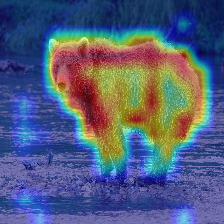

In [11]:
img_ary = show_cam_on_image(rgb_img, grayscale_cam)

image = ary_to_image(img_ary)

display(image)